# Model Tuning (and Necessary Preprocessing)

### Preprocessing

In [60]:
# Loading Data and making copy just in case

import pandas as pd

df = pd.read_csv("C:/Users/max dore/Desktop/Data3402 kaggle challenge (churn)/train.csv")
df2 = df.copy()

In [61]:
# DROPPING the "Surname" feature. It is not very relevant to predicting churn. (USED)

df2 = df2.drop(columns=['Surname'])

# Dropping CustomerID as well from the data frame. seems like an extension of ID and not very useful to the overall model
# (USED)

df2 = df2.drop(columns=['CustomerId'])

# Dropping 'Id' as well from the data frame. Not very useful to the overall model
# (USED)

df2 = df2.drop(columns=['id'])

In [62]:
#Applying one-hot coding to gender

import pandas as pd

df2 = pd.get_dummies(df2, columns=['Gender'], prefix='Gen')

In [63]:
#changing bool dtype to float (not sure why it changed to bool) for Gen

for column in df2.columns:
    if column.startswith('Gen_'):
        df2[column] = df2[column].astype(float)

In [64]:
#Applying one-hot coding to Geography (also have to change dtype to float from bool)

import pandas as pd


df2 = pd.get_dummies(df2, columns=['Geography'], prefix='Geo')

for column in df2.columns:
    if column.startswith('Geo_'):
        df2[column] = df2[column].astype(float)

In [65]:
#Standardizing the numerical columns that aren't encoded

from sklearn.preprocessing import StandardScaler

# 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'
columns_to_standardize = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()

df2[columns_to_standardize] = scaler.fit_transform(df2[columns_to_standardize])

In [66]:
df2.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gen_Female,Gen_Male,Geo_France,Geo_Germany,Geo_Spain
0,0.144135,-0.578074,-0.719973,-0.883163,0.814298,1.0,0.0,1.369486,0,0.0,1.0,1.0,0.0,0.0
1,-0.367706,-0.578074,-1.432694,-0.883163,0.814298,1.0,1.0,-1.254085,0,0.0,1.0,1.0,0.0,0.0
2,0.268974,0.211354,1.774548,-0.883163,0.814298,1.0,0.0,1.437422,0,0.0,1.0,1.0,0.0,0.0
3,-0.941966,-0.465299,-1.076334,1.486918,-1.013348,1.0,1.0,-0.557018,0,0.0,1.0,1.0,0.0,0.0
4,0.743362,-0.578074,-0.007253,-0.883163,0.814298,1.0,1.0,-1.938770,0,0.0,1.0,0.0,0.0,1.0


# ---------------------------------------------------------------------------------------

Results:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     39133
           1       0.73      0.56      0.63     10378

    accuracy                           0.86     49511
   macro avg       0.81      0.75      0.77     49511
weighted avg       0.86      0.86      0.86     49511

Accuracy: 0.8641917957625578


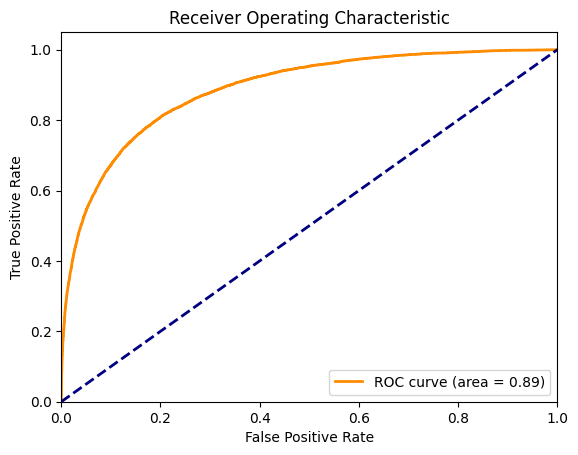

In [67]:
# Implementing XGB (no performance enhancements) again for comparison's sake

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

X = df2.drop('Exited', axis=1)
y = df2['Exited']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

print("Results:")
print(classification_report(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

#ROC and Graph
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# ---------------------------------------------------------------------------------------

## Tuning

### XGB with SMOTE Applied

Results:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     39133
           1       0.68      0.63      0.65     10378

    accuracy                           0.86     49511
   macro avg       0.79      0.77      0.78     49511
weighted avg       0.86      0.86      0.86     49511

Accuracy: 0.8586576720324777


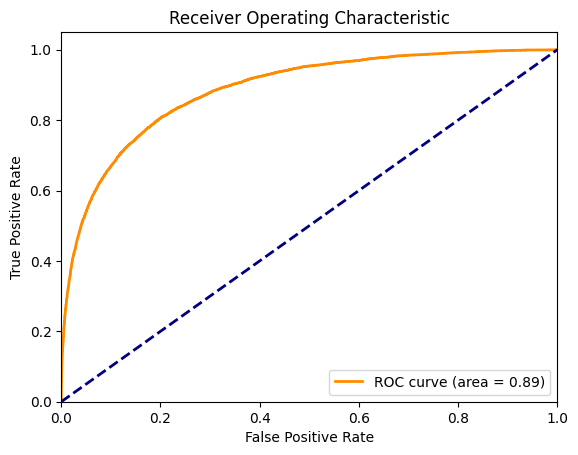

In [11]:
#XGB with SMOTE

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

X = df2.drop('Exited', axis=1)
y = df2['Exited']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# ------

# XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

model.fit(X_train_smote, y_train_smote)

y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

print("Results:")
print(classification_report(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

# ROC and Graph
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#### Using SMOTE, the positive class saw a moderate increase in recall, but also saw a slight drop in precision. The negative class saw a 0.01 point increase in precision but a slightly bigger decrease in recall. Also, the accuracy, though approximately the same, did see a slight drop from about 86.4 to 85.8. Overall, it seems as if implementing SMOTE may have caused a moderate increase in positive class recall, but at the price of a slight-moderate decrease in just about every other metric. Nonetheless, the performance stays largely the same. It seems that SMOTE would be useful if it was a priority that the algorithm pick up more positives.

# ---------------------------------------------------------------------------------------

### XGB with Hyperparameter Tuning Through Gridsearch (no SMOTE)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.5s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.3s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.9s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.7s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=   1.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=   1.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=   1.1s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=   0.5s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=   1.1s
[CV] END ...learning_rate=0.01, max_depth=5, n_e

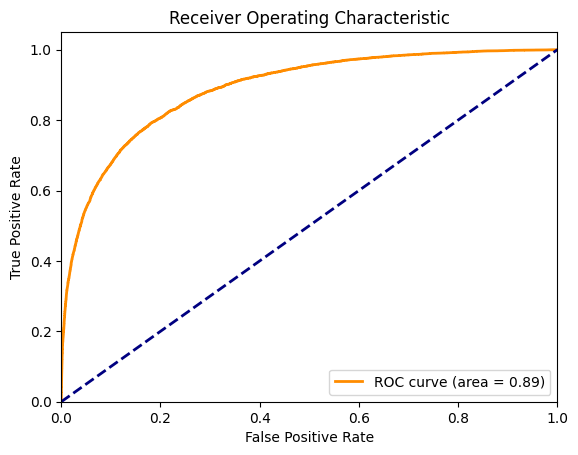

Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}
Best score: 0.8650571770644021


In [16]:
# XGB with Gridsearch hyperparameter tuning

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

X = df2.drop('Exited', axis=1)
y = df2['Exited']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Gridsearch parameters
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees
    'max_depth': [3, 5, 7],          # Depth of each tree
    'learning_rate': [0.01, 0.1, 0.2] # Step size shrinkage used to prevent overfitting.
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)[:, 1]

# Evaluation
print("Results:")
print(classification_report(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

# ROC and Graph
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)



Results:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     39133
           1       0.74      0.55      0.63     10378

    accuracy                           0.87     49511
   macro avg       0.82      0.75      0.78     49511
weighted avg       0.86      0.87      0.86     49511

Accuracy: 0.866029771161964


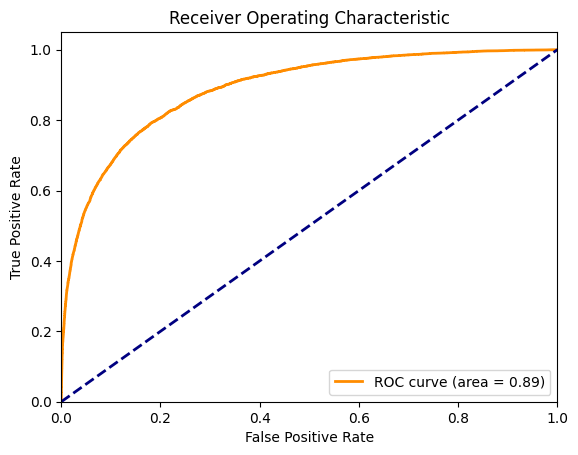

In [15]:
#running XGB again using the best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}

import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Best parameters
best_params = {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}
model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Evaluation
print("Results:")
print(classification_report(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

# ROC and Graph
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#### Compared to the original, this model has seen an overall slight increase in performance in accuracy, precision, and recall. When compared to the SMOTE model, It also shows a better all-around performance, however there is a moderate drop in positive class recall, as predicted. ROC remains constant across all three models. This is the highest overall accuracy has been with 0.87. However, after training the best parameters on a new training and validation set, there was no change.

# ---------------------------------------------------------------------------------------

### XGB with SMOTE and the Best Parameters (Found Through Gridsearch)

Results:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     39133
           1       0.61      0.71      0.66     10378

    accuracy                           0.84     49511
   macro avg       0.76      0.80      0.78     49511
weighted avg       0.85      0.84      0.85     49511

Accuracy: 0.8432267576902103


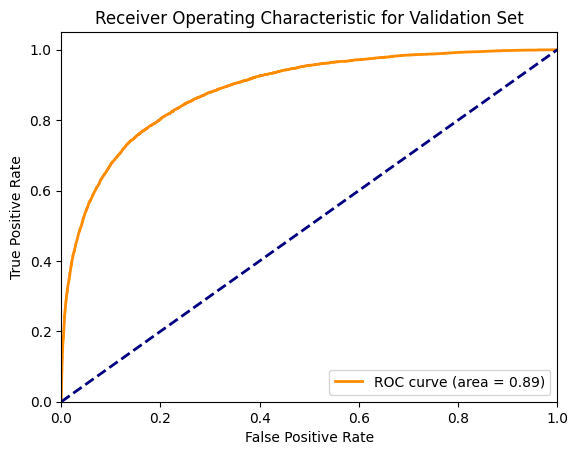

In [17]:
# XGB with best parameters and SMOTE

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import xgboost as xgb
import matplotlib.pyplot as plt

X = df2.drop('Exited', axis=1)
y = df2['Exited']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# best hyperparameters
best_params = {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}
model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)

model.fit(X_train_smote, y_train_smote)

y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Evaluation
print("Results:")
print(classification_report(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

# ROC and Graph
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Validation Set')
plt.legend(loc="lower right")
plt.show()


#### There was an overall decrease in performance, however SMOTE dramatically increased the recall for the positive class. Once again, this model with seems to work the same as the original SMOTE model, just more extreme and sharp when it comes to recall for the positive class.

### XGB with Bayesian Optimization (No SMOTE)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

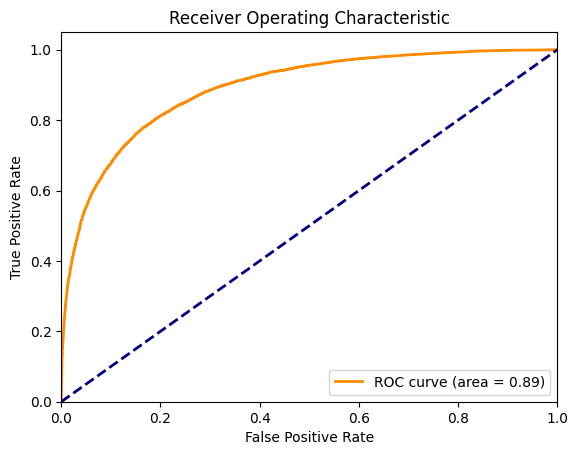

Best parameters found:  OrderedDict([('learning_rate', 0.13), ('max_depth', 4), ('n_estimators', 89)])
Best score from Bayesian Optimization:  0.8653601480099101


In [23]:
#XGB + Bayesian Optimization but no SMOTE

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import matplotlib.pyplot as plt

X = df2.drop('Exited', axis=1)
y = df2['Exited']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Search
search_spaces = {
    'learning_rate': Real(0.01, 0.13),
    'max_depth': Integer(3, 4),
    'n_estimators': Integer(50, 89)
}

# Bayesian optimization
bayes_search = BayesSearchCV(model, search_spaces, n_iter=32, scoring='accuracy', cv=3, n_jobs=-1, verbose=3)
bayes_search.fit(X_train, y_train)

best_model = bayes_search.best_estimator_

y_pred = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)[:, 1]

# Evaluation
print("Results:")
print(classification_report(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

# ROC and Graph
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("Best parameters found: ", bayes_search.best_params_)
print("Best score from Bayesian Optimization: ", bayes_search.best_score_)


Results:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     39133
           1       0.74      0.56      0.64     10378

    accuracy                           0.87     49511
   macro avg       0.82      0.75      0.78     49511
weighted avg       0.86      0.87      0.86     49511

Accuracy: 0.8664741168629193


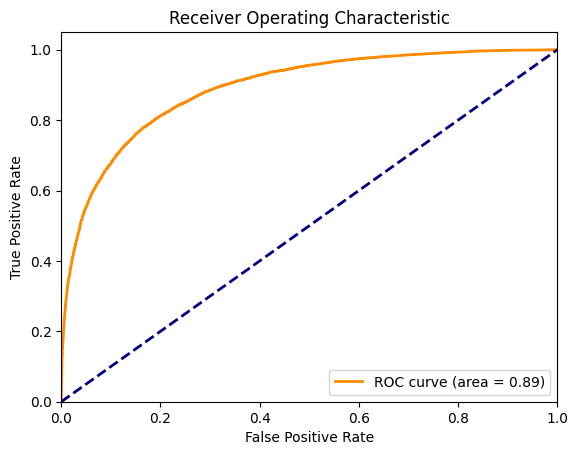

In [25]:
# Implementing the best parameters from bayesian optimization

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

X = df2.drop('Exited', axis=1)
y = df2['Exited']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Best parameters
best_params = {
    'learning_rate': 0.13,
    'max_depth': 4,
    'n_estimators': 89,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42
}

model = xgb.XGBClassifier(**best_params)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Evaluation
print("Results:")
print(classification_report(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

# ROC and Graph
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Overall this result turned out the same as the Gridsearch (with no SMOTE). There seems to be a very slight improvement to positive recall, but outside of that there was no major change.

#### It seems that XGB with best parameters gained from Bayesian optimization has seemed to perform the best.

Results:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     39133
           1       0.74      0.56      0.64     10378

    accuracy                           0.87     49511
   macro avg       0.82      0.75      0.78     49511
weighted avg       0.86      0.87      0.86     49511

Accuracy: 0.8664741168629193


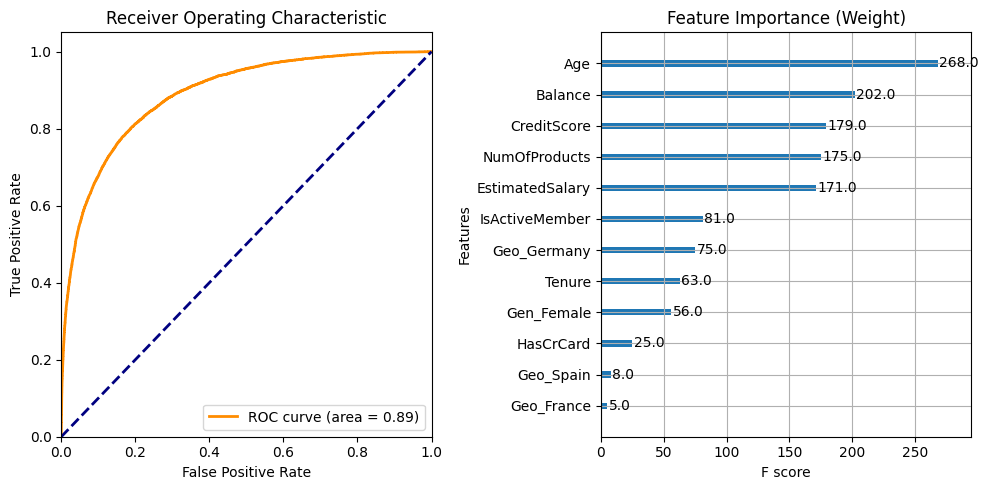

In [27]:
#Feature Importance

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from xgboost import plot_importance
import matplotlib.pyplot as plt

X = df2.drop('Exited', axis=1)
y = df2['Exited']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# optimized param
best_params = {
    'learning_rate': 0.13,
    'max_depth': 4,
    'n_estimators': 89,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42
}
model = xgb.XGBClassifier(**best_params)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Evaluation
print("Results:")
print(classification_report(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

# ROC and Graph
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Feature Importance Graph
plt.subplot(1, 2, 2)
plot_importance(model, importance_type='weight', ax=plt.gca(), title='Feature Importance (Weight)')
plt.tight_layout()

plt.show()


### Trying the same bayesian optimized model after dropping Geo_Spain, Geo_Germany, and Geo_France

Results:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     39133
           1       0.73      0.52      0.61     10378

    accuracy                           0.86     49511
   macro avg       0.81      0.74      0.76     49511
weighted avg       0.85      0.86      0.85     49511

Accuracy: 0.8592635979883259


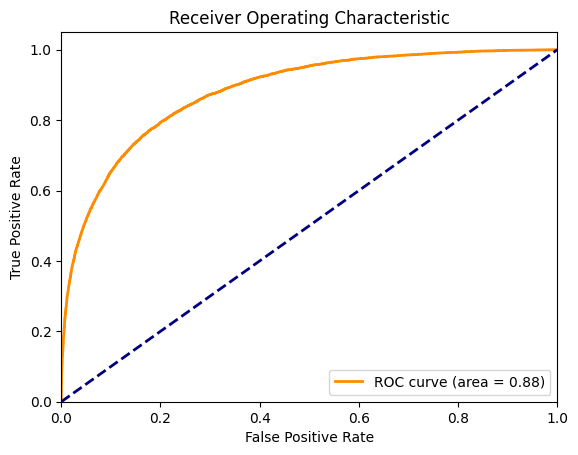

In [28]:
# Algo after dropping Geo_xxxxx

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Drop Geo_France, Geo_Germany, and Geo_Spain from the feature set just for this run
X = df2.drop(['Exited', 'Geo_France', 'Geo_Germany', 'Geo_Spain'], axis=1)
y = df2['Exited']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Best parameters
best_params = {
    'learning_rate': 0.13,
    'max_depth': 4,
    'n_estimators': 89,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42
}

model = xgb.XGBClassifier(**best_params)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Evaluation
print("Results:")
print(classification_report(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

# ROC and Graph
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#### Performance dropped in most metrics, so removing Geo_Spain, Geo_Germany, and Geo_France did not help

Results:
              precision    recall  f1-score   support

           0       0.92      0.87      0.90     39133
           1       0.60      0.72      0.66     10378

    accuracy                           0.84     49511
   macro avg       0.76      0.80      0.78     49511
weighted avg       0.85      0.84      0.85     49511

Accuracy: 0.8417119428005898
Full ROC AUC: 0.887026


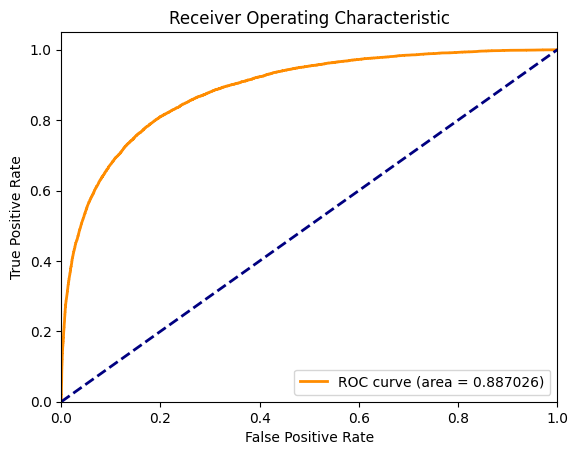

In [39]:
# Bayesian Model with full ROC number + SMOTE

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

X = df2.drop(['Exited'], axis=1)
y = df2['Exited']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Best parameters
best_params = {
    'learning_rate': 0.13,
    'max_depth': 4,
    'n_estimators': 89,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42
}

model = xgb.XGBClassifier(**best_params)

model.fit(X_train_smote, y_train_smote)

y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Evaluation
print("Results:")
print(classification_report(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

# ROC and Graph
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"Full ROC AUC: {roc_auc:.6f}")  # Display the ROC AUC value with six decimal places

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.6f})')  # Full ROC AUC value in the label
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#### Accuracy took a significant hit with the SMOTE + Bayesian optimized model. ROC took a very slight hit, although approximately still identical to Bayesian Model without SMOTE. As expected, however, positive recall jumped significantly. Unfortunately, that is followed by a significant decrease in positive precision. Overall, the model is not as robust with SMOTE as it is without, though it is much better at identifying full amount of the positive class

Results:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     39133
           1       0.74      0.56      0.64     10378

    accuracy                           0.87     49511
   macro avg       0.82      0.75      0.78     49511
weighted avg       0.86      0.87      0.86     49511

Accuracy: 0.8664741168629193


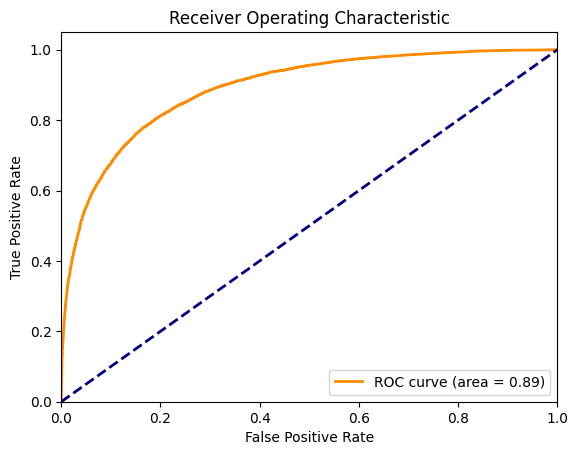

In [73]:
# Implementing the best parameters from bayesian optimization

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

X = df2.drop('Exited', axis=1)
y = df2['Exited']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Best parameters
best_params = {
    'learning_rate': 0.13,
    'max_depth': 4,
    'n_estimators': 89,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42
}

model = xgb.XGBClassifier(**best_params)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Evaluation
print("Results:")
print(classification_report(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

# ROC and Graph
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Conclusively, it seems that the bayesian optimized model, with its best parameters and no SMOTE, seems to be the best all around.

#### Cross Validation seemed to not affect the metrics either

[0]	validation_0-logloss:0.47988	validation_1-logloss:0.47719
[1]	validation_0-logloss:0.45220	validation_1-logloss:0.44962
[2]	validation_0-logloss:0.43100	validation_1-logloss:0.42876
[3]	validation_0-logloss:0.41436	validation_1-logloss:0.41221
[4]	validation_0-logloss:0.40040	validation_1-logloss:0.39843
[5]	validation_0-logloss:0.38910	validation_1-logloss:0.38721
[6]	validation_0-logloss:0.38001	validation_1-logloss:0.37824
[7]	validation_0-logloss:0.37113	validation_1-logloss:0.36957
[8]	validation_0-logloss:0.36456	validation_1-logloss:0.36295
[9]	validation_0-logloss:0.35899	validation_1-logloss:0.35741
[10]	validation_0-logloss:0.35438	validation_1-logloss:0.35281
[11]	validation_0-logloss:0.35073	validation_1-logloss:0.34910
[12]	validation_0-logloss:0.34661	validation_1-logloss:0.34503
[13]	validation_0-logloss:0.34374	validation_1-logloss:0.34215
[14]	validation_0-logloss:0.34154	validation_1-logloss:0.33997
[15]	validation_0-logloss:0.33883	validation_1-logloss:0.33732
[1

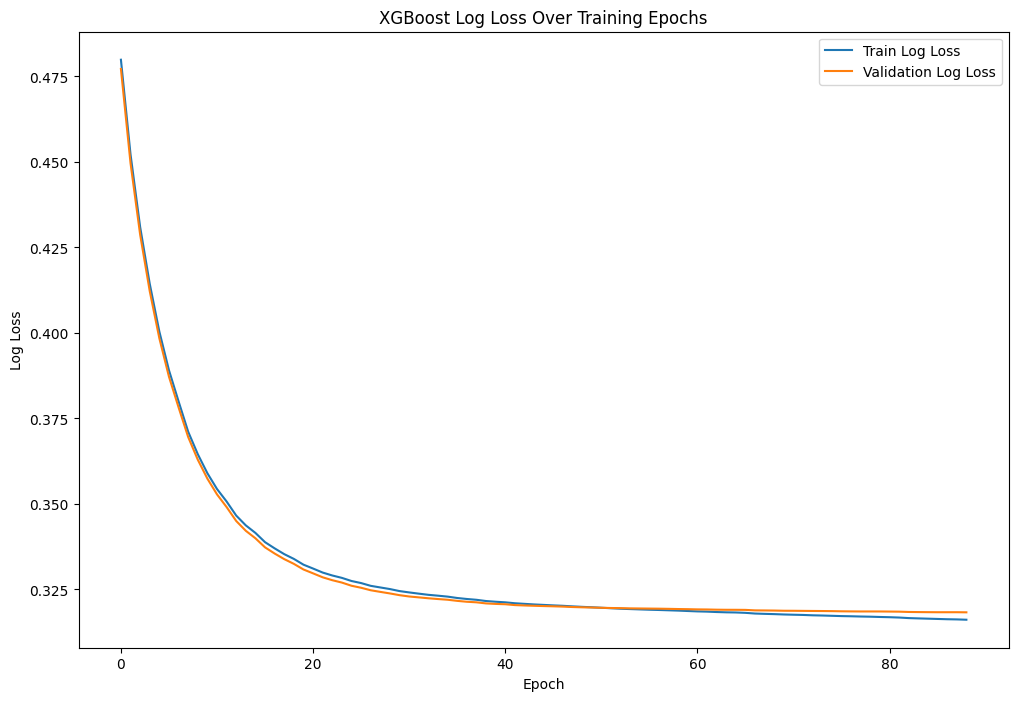

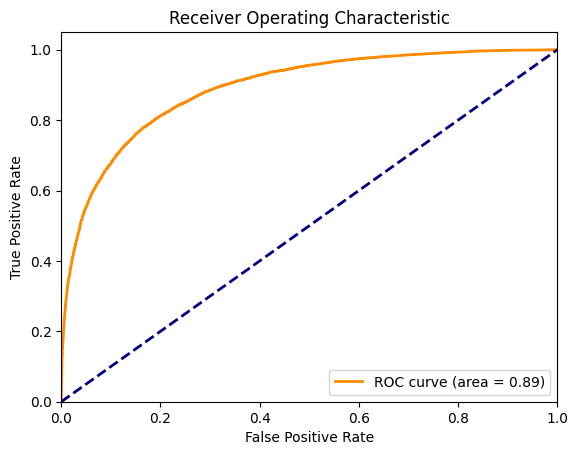

In [75]:
# LOG LOSS

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

X = df2.drop('Exited', axis=1)
y = df2['Exited']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Best parameters
best_params = {
    'learning_rate': 0.13,
    'max_depth': 4,
    'n_estimators': 89,
    'use_label_encoder': False,
    'random_state': 42
}

model = xgb.XGBClassifier(**best_params)
model.set_params(eval_metric='logloss')  # Set eval_metric using set_params

# Track the log loss across each iteration
eval_set = [(X_train, y_train), (X_val, y_val)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Evaluation
print("Results:")
print(classification_report(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

# Extract log loss values from the model's evaluation results
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# Plot log loss over epochs
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train Log Loss')
ax.plot(x_axis, results['validation_1']['logloss'], label='Validation Log Loss')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('Epoch')
plt.title('XGBoost Log Loss Over Training Epochs')
plt.show()

# ROC and Graph
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [77]:
#Comparison of best ouputs

from tabulate import tabulate

# Define your data in a more condensed form
data = [
    ["XGB with Bayesian Tuning", 0.89, 0.95, 0.92, 0.74, 0.56, 0.64, 0.87, 0.86647],
    ["XGB with Best Parameters (GridSearch)", 0.89, 0.95, 0.92, 0.74, 0.55, 0.63, 0.87, 0.86603],
    ["XGB with SMOTE", 0.90, 0.92, 0.91, 0.68, 0.63, 0.65, 0.86, 0.85866]
]

# Define your headers, focusing on the most relevant metrics
headers = ["Model", "Precision (0)", "Recall (0)", "F1-Score (0)",
           "Precision (1)", "Recall (1)", "F1-Score (1)", "Accuracy", "ROC AUC"]

# Create the table with 'plain' format for better readability
table = tabulate(data, headers=headers, tablefmt="plain")

print(table)


Model                                    Precision (0)    Recall (0)    F1-Score (0)    Precision (1)    Recall (1)    F1-Score (1)    Accuracy    ROC AUC
XGB with Bayesian Tuning                          0.89          0.95            0.92             0.74          0.56            0.64        0.87    0.86647
XGB with Best Parameters (GridSearch)             0.89          0.95            0.92             0.74          0.55            0.63        0.87    0.86603
XGB with SMOTE                                    0.9           0.92            0.91             0.68          0.63            0.65        0.86    0.85866
